Detected Tag: 5 at center: [504.77053046 162.43879709]
Detected Tag: 5 at center: [229.29193283 173.52321164]


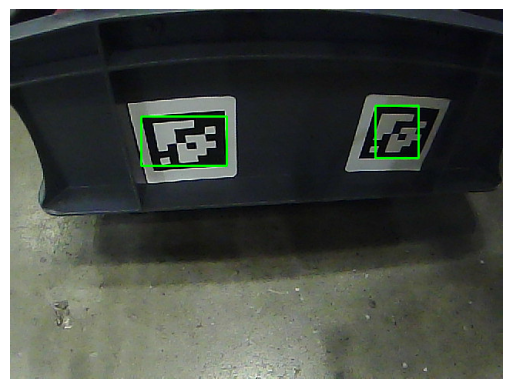

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import apriltag

show_bbox = True

# Load the image
path = "dataset/may15_run00_cam07/frame_380.png"
image = cv2.imread(path)

# Initialize the AprilTag detector
detector = apriltag.Detector()

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect AprilTags in the image
tags = detector.detect(gray_image)

# Draw bounding boxes around detected tags
for tag in tags:
    print('Detected Tag:', tag.tag_id, 'at center:', tag.center)

    if show_bbox:
        # Get the corners of the tag
        corners = tag.corners
        # Draw the bounding box
        pt1 = (int(corners[0][0]), int(corners[0][1]))
        pt2 = (int(corners[2][0]), int(corners[2][1]))
        cv2.rectangle(image, pt1, pt2, (0, 255, 0), 2)

# Convert the color space from BGR to RGB to display using matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


### Trying bounding box with canny edge detection

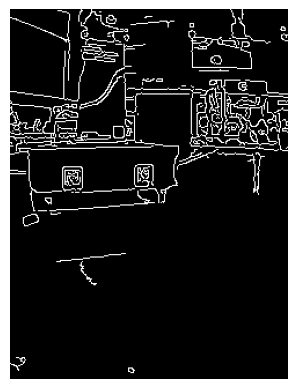

In [72]:
import cv2
import numpy as np

# Function to perform the operations
def find_bounding_boxes(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return
    
    # Rotate the image 90 degrees anticlockwise
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to smooth the image and reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop over the contours
    for contour in contours:
        # Approximate the contour to a polygon
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # The contour is considered a rectangle if it has 4 vertices
        if len(approx) == 4:
            # Compute the bounding box of the contour and draw it on the image
            (x, y, w, h) = cv2.boundingRect(approx)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Show the output image
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()

# Call the function with the path to your image
find_bounding_boxes("dataset/frame_6500.png")


Finding bounding boxes for image dataset/frame_2520.png


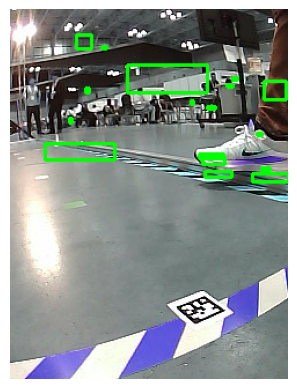

In [5]:
bins = 7040 // 20

import random

path = f"dataset/frame_{random.randint(0, bins) * 20}.png"
print(f"Finding bounding boxes for image {path}")
find_bounding_boxes(path)

### Trying yolov8 directly


0: 640x480 1 person, 1 tv, 1 oven, 2 refrigerators, 61.2ms
Speed: 2.6ms preprocess, 61.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


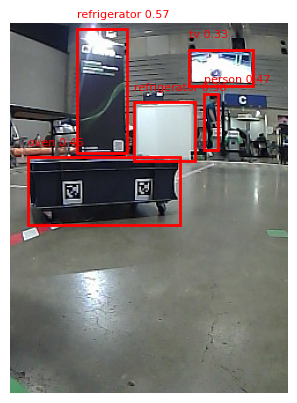

In [15]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Load a model
model = YOLO("yolov8n.pt")  # Make sure to use the correct model file

# Load and rotate the image using PIL
path = "dataset/frame_6500.png"
image = Image.open(path)
image = image.rotate(90, expand=True)  # Rotate 90 degrees anticlockwise

# Perform object detection on the image
results = model.predict(source=image)

# Extract bounding boxes, classes, names, and confidences
boxes = results[0].boxes.xyxy.tolist()
classes = results[0].boxes.cls.tolist()
names = results[0].names
confidences = results[0].boxes.conf.tolist()

# Convert PIL image to array for matplotlib
image_np = np.array(image)

# Create figure and axes
fig, ax = plt.subplots(1)
ax.imshow(image_np)

# Iterate through the results and add bounding boxes to the image
for box, cls, conf in zip(boxes, classes, confidences):
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 10, f"{names[int(cls)]} {conf:.2f}", color='red', fontsize=8)

# Display the image
plt.axis('off')  # Turn off axis
plt.show()

Looks like yolov8 could work with decent accuracy with oven being similar to the cart. Inference time about 100ms should be sufficient for our use case.

In [17]:
# Detected objects
detected_objects = set([d["name"] for d in results[0].summary()])
print(detected_objects)

{'person', 'refrigerator', 'tv', 'oven'}


In [19]:
# put into function and randomize to check against a few image paths to check if oven is good enough

def detect(path):
    from ultralytics import YOLO
    from PIL import Image
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    # Load a model
    model = YOLO("yolov8n.pt")  # Make sure to use the correct model file

    # Load and rotate the image using PIL
    image = Image.open(path)
    image = image.rotate(90, expand=True)  # Rotate 90 degrees anticlockwise

    # Perform object detection on the image
    results = model.predict(source=image)

    # Extract bounding boxes, classes, names, and confidences
    boxes = results[0].boxes.xyxy.tolist()
    classes = results[0].boxes.cls.tolist()
    names = results[0].names
    confidences = results[0].boxes.conf.tolist()

    # Convert PIL image to array for matplotlib
    image_np = np.array(image)

    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)

    # Iterate through the results and add bounding boxes to the image
    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 10, f"{names[int(cls)]} {conf:.2f}", color='red', fontsize=8)

    # Display the image
    plt.axis('off')  # Turn off axis
    plt.show()

In [25]:
def get_random_image_path(directory_path):
    import os
    import random

    # List all files in the directory
    files = os.listdir(directory_path)

    # Filter for PNG files
    png_files = [file for file in files if file.endswith('.png')]

    # Randomly select a PNG file
    random_png = random.choice(png_files) if png_files else None

    # Print or use the selected file
    if random_png:
        print(f"Randomly selected PNG file: {random_png}")
        return os.path.join(directory_path, random_png)
    else:
        print("No PNG files found in the directory.")

In [26]:
def detect_random():
    # Specify the directory containing the images
    directory_path = 'dataset'

    random_image = get_random_image_path(directory_path)

    if not random_image:
        print("Could not find random image path. Exiting detect_random")
        return

    detect(random_image)

Randomly selected PNG file: frame_2360.png

0: 640x480 6 persons, 51.2ms
Speed: 1.3ms preprocess, 51.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


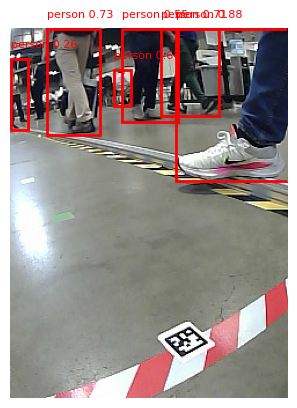

In [39]:
detect_random()

On further random testing, it looks like the oven feature name doesn't predict the cart accurately. Sommetimes it is classified as suitcase. Other times, it is not found at all. To improve this, we'll probably need to do our own custom yolov8 object detection.

### Detecting the yellow black line

/tmp/ipykernel_41013/2306667383.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x*vy/vx) + y)
/tmp/ipykernel_41013/2306667383.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  righty = int(((image.shape[1]-x)*vy/vx)+y)


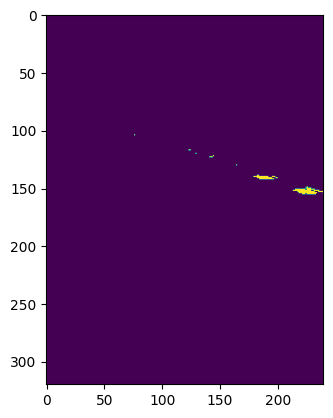

In [67]:
import cv2
import numpy as np
from PIL import Image

def rotate_image(image, angle):
    """Rotate image using PIL for more flexibility with angles and expansion."""
    image_pil = Image.fromarray(image)
    rotated_pil = image_pil.rotate(angle, expand=True)
    return np.array(rotated_pil)

def find_yellow_line(image_path, rotation_angle=90):
    """Find and draw a straight line representing yellow tape on the surface, after rotating the image."""
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return
    
    # Rotate the image
    image = rotate_image(image, rotation_angle)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define HSV range for yellow and create a mask
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    plt.imshow(mask)

    # Find points in the mask
    points = np.column_stack(np.where(mask.transpose() > 0))
    
    # Fit a line to these points
    if len(points) > 0:
        [vx, vy, x, y] = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
        lefty = int((-x*vy/vx) + y)
        righty = int(((image.shape[1]-x)*vy/vx)+y)
        cv2.line(image, (image.shape[1]-1,righty), (0,lefty), (0,255,0), 3)

    return image

# Load and process the image
path = 'dataset/frame_2360.png'
processed_image = find_yellow_line(path)



# Display the results
# plt.imshow(processed_image)
# plt.axis('off')
# plt.show()

### Detecting the yellow black line

Use only the red points for forming the red white line

/tmp/ipykernel_41013/2042494828.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x*vy/vx) + y)
/tmp/ipykernel_41013/2042494828.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  righty = int(((image.shape[1]-x)*vy/vx)+y)


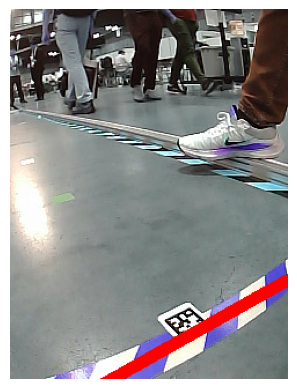

In [63]:
import cv2
import numpy as np
from PIL import Image

def rotate_image(image, angle):
    """Rotate image using PIL for more flexibility with angles and expansion."""
    image_pil = Image.fromarray(image)
    rotated_pil = image_pil.rotate(angle, expand=True)
    return np.array(rotated_pil)

def find_red_line(image_path, rotation_angle=90):
    """Find and draw a straight line representing red tape on the surface, after rotating the image."""
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return
    
    # Rotate the image
    image = rotate_image(image, rotation_angle)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define HSV range for red color and create masks
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([179, 255, 255])
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)

    # plt.imshow(mask_red)

    # Define the foreground region (lower third of the image)
    height = image.shape[0]
    foreground_region = mask_red[int(2 * height / 3):height, :]

    # Clean up the mask using morphological operations
    kernel = np.ones((5,5), np.uint8)
    foreground_region = cv2.morphologyEx(foreground_region, cv2.MORPH_CLOSE, kernel)

    # Find points in the red mask within the foreground
    points = np.column_stack(np.where(foreground_region.transpose() > 0))
    points[:, 1] += int(2 * height / 3)  # Adjust y-coordinates to original image scale
    
    # Fit a line to these points
    if len(points) > 0:
        [vx, vy, x, y] = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
        lefty = int((-x*vy/vx) + y)
        righty = int(((image.shape[1]-x)*vy/vx)+y)
        cv2.line(image, (image.shape[1]-1,righty), (0,lefty), (255,0,0), 10)  # Red line for visibility

    return image

# Load and process the image
path = 'dataset/frame_2360.png'
processed_image = find_red_line(path)


# # Display the results
plt.imshow(processed_image)
plt.axis('off')
plt.show()